## Введение

Описание проекта:
Отток клиентов
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены данные о поведении клиентов и расторжении договоров с банком.


Алгоритм работы:
   1. Введение
   2. Обзор и предобработка данных
   3. Разделим данные на обучающую, валидационную и тестовую выборки
   4. Обучим разные модели без учета дисбаланса в классах
   5. Повторим пункт 4 с учетом дисбаланса
   6. Общий вывод

Описание данных
Данные находятся в файле /datasets/Churn.csv


Известно:

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак:

    Exited — факт ухода клиента

## Обзор и предобработка данных

Импортируем библиотеки

In [24]:
import urllib.request
import pandas as pd

from os import path
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

Загрузим и посмотрим датасет

In [25]:
YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_name = 'Churn.csv'

#download dataset if not existed
if not path.exists(dataset_folder + '/' + dataset_name):
    #create dir if not existed
    Path(dataset_folder).mkdir(parents=True, exist_ok=True)

    #download dataset
    urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                               dataset_folder + '/' + dataset_name)

df = pd.read_csv(dataset_folder + '/' + dataset_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Имеются пропуски в параметре Tenure. Посмотрим гистограммы

array([[<AxesSubplot:title={'center':'RowNumber'}>,
        <AxesSubplot:title={'center':'CustomerId'}>,
        <AxesSubplot:title={'center':'CreditScore'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Tenure'}>,
        <AxesSubplot:title={'center':'Balance'}>],
       [<AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'HasCrCard'}>,
        <AxesSubplot:title={'center':'IsActiveMember'}>],
       [<AxesSubplot:title={'center':'EstimatedSalary'}>,
        <AxesSubplot:title={'center':'Exited'}>, <AxesSubplot:>]],
      dtype=object)

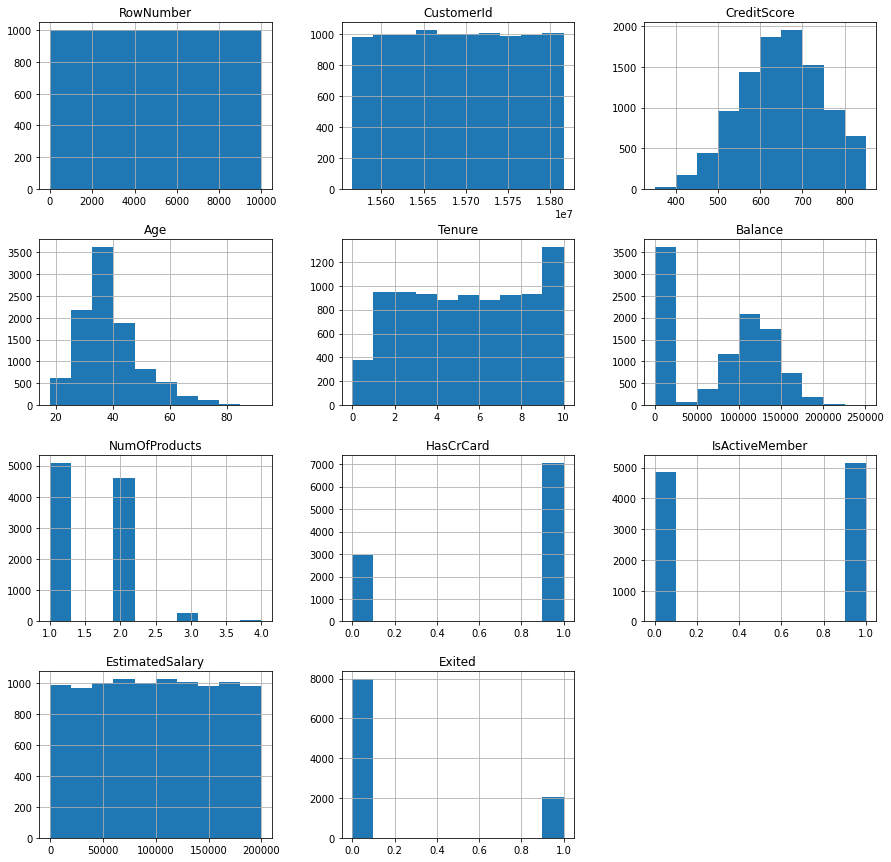

In [26]:
df.hist(figsize=(15,15))

Вывод: целевой параметр 'Exited' имеет сильный перекос в сторону нулей

Посмотрим значения категориальных столбцов

In [27]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [28]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Проверим дупликаты

In [29]:
df.duplicated().sum()

0

Заполним пропуски в 'Tenure' медианными значениями. Для этого посмотрим корреляцию этого параметра с остальными. На основании этого сделаем сводную таблицу через которую заполним пропуски

In [30]:
df.corr()['Tenure']

RowNumber         -0.007322
CustomerId        -0.021418
CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
Name: Tenure, dtype: float64

Наибольшая корреляция из значимых признаков с 'IsActiveMember' и 'HasCrCard'. Заполним пропуски

In [31]:
df['Tenure'] = df.groupby(['IsActiveMember', 'HasCrCard' ])['Tenure'].apply(lambda x: x.fillna(x.median()))

Удалим ненужные признаки из датасета и выполним One-Hot Encoding категориальных значений

In [32]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df = pd.get_dummies(df, drop_first=True)

Посмотрим результат

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [34]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Вывод: мы выполнили прямое кодирование категориальных признаков и заполнили пропуски. Целевой признак несбалансирован в сторону "0"

## Разделение данных на обучающую, валидационную и тестовую выборки

Разделим данные на обучающую, валидационную и тестовую выборки. Для этого напишем функцию разделения выборки на обучающую и остальную. А остальную разделим на валидационную и тестовую. Функция возвращает словарь по каждой из выборок.
Например:


 df_data['train']['X'] - это features обучающей выборки


 df_data['test']['y'] - это targets тестовой выборки

In [35]:
# split data to train, validation and test samples
# train_rem_size is proportion between train and remain samples
# valid_test_size is proportion between valid and test samples in remain part
def split_train_valid_test(X, y, train_rem_size, valid_test_size):

    #split to train and remain
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_rem_size, random_state=123)

    #split to valid and test
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size=valid_test_size, random_state=123)

    df_data = {'train': {'X': X_train, 'y': y_train},
               'valid': {'X': X_valid, 'y': y_valid},
               'test': {'X': X_test, 'y': y_test}}

    return df_data

Сделаем разделение

In [36]:
X = df.drop(['Exited'], axis=1)
y = df['Exited'].copy()
data = split_train_valid_test(X, y, 0.8, 0.5)

Вывод: мы разбили выборку на обучающую и остальную в пропорции 0.8 к 0.2. А остальную разбили попалам между валидационной и тестовой

## Обучение моделей без учета дисбаланса в классах

Напишем функцию которая будет возвращать GridSearch для моделей LogisticRegression, DecisionTreeClassifier, RandomForestClassifier с заданными параметрами скоринга, класса весов, кол-ва исполняемых потоков

In [37]:
#return GridSearch for LogisticRegression, DecisionTreeClassifier, RandomForestClassifier with parameters
def get_grid_params(
                    depth=        10,
                    est =         200,
                    depth_step=   4,
                    step_est =    10,
                    scoring=      'f1',
                    class_weight= None,
                    njobs=        12,
                    refit=        True):

    pipeline = Pipeline([('clf', LogisticRegression(random_state=123))])
    parameters = [
        {
            'clf': (LogisticRegression(random_state=123),),
            'clf__class_weight': [class_weight]
        }, {
            'clf': (DecisionTreeClassifier(random_state=123),),
            'clf__max_depth': range(1, depth, depth_step),
            'clf__class_weight': [class_weight]

        }, {
            'clf': (RandomForestClassifier(random_state=123),),
            'clf__n_estimators': range(1, est, step_est),
            'clf__max_depth': range(1, depth, depth_step),
            'clf__class_weight': [class_weight]

        }
    ]

    return GridSearchCV(pipeline, parameters, scoring=scoring, n_jobs=njobs, refit=refit)

Напишем функцию, которая фитит данные в полученный GridSearch и выводит информацию о лучшей модели: основные параметры, F1 и AUC-ROC метрики для валидационной и тестовой модели

In [38]:
# fit data in grid search and print best estimator parameters and
# F1, AUC-ROC for valid and test samples
def fit_and_results(data,
                    grid_search):

    grid_search.fit(data['train']['X'], data['train']['y'])
    print('Best estimator parameters:')
    print(grid_search.best_params_)
    print('F1 valid score:')
    print(grid_search.best_score_)
    print('F1 test score:')
    test_score = f1_score(grid_search.
                          best_estimator_.
                          predict(data['test']['X']), data['test']['y'])
    print(test_score)
    roc_valid_score = roc_auc_score(grid_search.
                                    best_estimator_.
                                    predict(data['valid']['X']), data['valid']['y'])
    roc_test_score = roc_auc_score(grid_search.
                                   best_estimator_.
                                   predict(data['test']['X']), data['test']['y'])
    print('AUC-ROC valid score:')
    print(roc_valid_score)
    print('AUC-ROC test score:')
    print(roc_test_score)


Получим наилучшую модель без учета дисбаланса:

In [39]:
grid_search = get_grid_params(depth=30,
                              depth_step=5,
                              est=500,
                              step_est=50,
                              scoring='f1',
                            )

fit_and_results(data, grid_search)

Best estimator parameters:
{'clf': RandomForestClassifier(max_depth=21, n_estimators=151, random_state=123), 'clf__class_weight': None, 'clf__max_depth': 21, 'clf__n_estimators': 151}
F1 valid score:
0.58437433468992
F1 test score:
0.5602409638554217
AUC-ROC valid score:
0.8352815434153205
AUC-ROC test score:
0.8198863636363636


Вывод: наилучшая модель без учета дисбаланса оказалась RandomForestClassifier(max_depth=21, n_estimators=151) и показала на тестовой выборке f1 = 0.56 и AUC-ROC = 0.83


<div class="alert alert-info"> По твоему совету увеличил диапазоны depth\est, добавил для них шаги. Пересчитал каждый этап, исправил вывод

## Обучeние моделей c учетом дисбаланса в классах

Получим наилучшую модель c учетом дисбаланса, для этого укажем параметр class_weight равным 'balanced':

In [40]:
grid_search = get_grid_params(depth=17,
                              depth_step=4,
                              est=200,
                              step_est=20,
                              scoring='f1',
                              class_weight='balanced',)

fit_and_results(data, grid_search)

Best estimator parameters:
{'clf': RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=141,
                       random_state=123), 'clf__class_weight': 'balanced', 'clf__max_depth': 9, 'clf__n_estimators': 141}
F1 valid score:
0.6161108930129171
F1 test score:
0.6353467561521253
AUC-ROC valid score:
0.7610502658730798
AUC-ROC test score:
0.75637602558754


Вывод: балансировка классов увеличила F1(0.635 против 0.56), но уменьшила AUC-ROC(0.76 против 0.8)

Попробуем улучшить параметры с помощью апсемплинга. Для этого найдем отношение между положительными и отрицательными таргетами

In [41]:
df = df.copy()
n_repeat = round(len(df[df['Exited'] == 0]) / len(df[df['Exited'] == 1]))

Сделаем функцию для реализации апсемплинга

In [42]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)

    return features_upsampled, target_upsampled

Сделаем разделение и апсемплим обучающую выборку с помощью полученного соотношения

In [43]:
data = split_train_valid_test(X, y, 0.8, 0.5)
data['train']['X'], data['train']['y'] = upsample(data['train']['X'], data['train']['y'], n_repeat)

Проверим полученное соотношение таргетов

In [44]:
data['train']['y'].value_counts()

1    6492
0    6377
Name: Exited, dtype: int64

Найдем наилучшую модель

In [45]:
grid_search = get_grid_params(depth=17,
                              depth_step=4,
                              est=100,
                              step_est=20,
                              scoring='f1',
                              class_weight='balanced',)

fit_and_results(data, grid_search)

Best estimator parameters:
{'clf': RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=81,
                       random_state=123), 'clf__class_weight': 'balanced', 'clf__max_depth': 13, 'clf__n_estimators': 81}
F1 valid score:
0.9312720773993393
F1 test score:
0.6201923076923076
AUC-ROC valid score:
0.7758835360597645
AUC-ROC test score:
0.7640407921962755


Вывод: апсемплинг немного увеличил F1 метрику(0.64 против 0.635), и AUC-ROC (0.77 против 0.76) на тестовой модели.

## Общий вывод:

Мы провели исследование клиентской базы "Бета-Банка". Целью работы было построение модели прогнозирующей уход клиента в ближайшее время. Мы заполнили пропуски и разделили выборки на обучающую, валидационую и тестовую. Меняя модели и их гиперпараметры, мы старались получить максимальный показатель F1. По результатам исследования полученная модель обладает следующими показателями на тестовом семпле:


RandomForestClassifier(max_depth=13, n_estimators=161, class_weight='balanced'):
F1:      0.641
AUC-ROC: 0.77


Рекомендации: сделать выгрузку с отсутствием пропусков в параметре 'Tenure' и сбалансированную по целевому показателю 'Exited'